In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2
import os

import albumentations

In [3]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, fold_idx, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            # if train_acc > best_acc: => moi luu
            torch.save(model.state_dict(), "save_model/fold_{}_epoch_{}_acc{}.pth".format(fold_idx+1, epoch, valid_acc))
            # best_acc = train_acc
            # print("[INFO] save_model/fold_{}_epoch_{}_acc{}.pth".format(fold_idx+1, epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [4]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    label = np.array(self.one_hot_label[self.list_labels[idx]]) # .astype('float')

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)

    image = image.transpose(2, 0, 1)
    sample = (image, label)

    return sample # image, label

In [13]:
def get_transforms(image_size=(224, 224)):

    transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        # albumentations.Resize(image_size, image_size),
        # albumentations.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        albumentations.Normalize()
    ])

    transforms_val = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        # albumentations.Resize(image_size, image_size),
        # albumentations.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [14]:
transforms_train, transforms_val = get_transforms(image_size=(224, 224))

In [15]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms_train)
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms_val)

In [8]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    return train_loader, val_loader

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = resnet18(num_classes=2)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

In [10]:
num_folds = 3
splits = KFold(n_splits=num_folds,shuffle=True,random_state=42)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

############### Fold 1 ###############
Epochs: 0, Train_loss: 0.7058737987563724, Valid_loss: 0.6264952733403161, Train_accuracy: 63.615903975994, Valid_accuracy: 64.91754122938531
Epochs: 1, Train_loss: 0.6520721458253407, Valid_loss: 0.6641189058621725, Train_accuracy: 62.19054763690923, Valid_accuracy: 62.21889055472264
Epochs: 2, Train_loss: 0.6285145538193839, Valid_loss: 0.908446627003806, Train_accuracy: 54.38859714928732, Valid_accuracy: 52.7736131934033
Epochs: 3, Train_loss: 0.6372733456747872, Valid_loss: 0.5552228845301128, Train_accuracy: 67.66691672918229, Valid_accuracy: 70.31484257871064
Epochs: 4, Train_loss: 0.6082255130722409, Valid_loss: 0.6252349529947553, Train_accuracy: 66.24156039009752, Valid_accuracy: 65.36731634182908
Epochs: 5, Train_loss: 0.607497167019617, Valid_loss: 0.6083701636110034, Train_accuracy: 63.99099774943736, Valid_accuracy: 62.06896551724138
Epochs: 6, Train_loss: 0.5682312030167807, Valid_loss: 0.6084724111216409, Train_accuracy: 66.84171042

<ipython-input-3-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.6921084324518839, Valid_loss: 0.6791529258092245, Train_accuracy: 61.21530382595649, Valid_accuracy: 59.820089955022496
Epochs: 1, Train_loss: 0.6283135839870998, Valid_loss: 0.714848402000609, Train_accuracy: 67.96699174793699, Valid_accuracy: 59.52023988005997
Epochs: 2, Train_loss: 0.6219226732140496, Valid_loss: 0.6563149520329067, Train_accuracy: 67.59189797449362, Valid_accuracy: 59.070464767616194
Epochs: 3, Train_loss: 0.6079414188861847, Valid_loss: 0.8705979245049613, Train_accuracy: 60.91522880720181, Valid_accuracy: 54.27286356821589
Epochs: 4, Train_loss: 0.5909905291738964, Valid_loss: 0.6899577946889968, Train_accuracy: 67.74193548387096, Valid_accuracy: 58.47076461769115
Epochs: 5, Train_loss: 0.5746678596451169, Valid_loss: 0.637462854385376, Train_accuracy: 72.46811702925731, Valid_accuracy: 64.31784107946027
Epochs: 6, Train_loss: 0.546060520268622, Valid_loss: 0.7163330344926744, Train_accuracy: 69.5423855963991, Valid_accuracy: 60.269865067

<ipython-input-3-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.68296065784636, Valid_loss: 0.6541361184347243, Train_accuracy: 62.06896551724138, Valid_accuracy: 59.60960960960961
Epochs: 1, Train_loss: 0.6288134129274459, Valid_loss: 0.7326151558331081, Train_accuracy: 59.14542728635682, Valid_accuracy: 60.06006006006006
Epochs: 2, Train_loss: 0.6243141967625845, Valid_loss: 0.7958929595493135, Train_accuracy: 60.11994002998501, Valid_accuracy: 58.408408408408405
Epochs: 3, Train_loss: 0.6017044463327953, Valid_loss: 0.6098351961090451, Train_accuracy: 72.71364317841079, Valid_accuracy: 64.86486486486487
Epochs: 4, Train_loss: 0.5841253385657356, Valid_loss: 0.6363599044936044, Train_accuracy: 69.11544227886057, Valid_accuracy: 68.16816816816817
Epochs: 5, Train_loss: 0.58341483771801, Valid_loss: 0.6815982205527169, Train_accuracy: 67.09145427286357, Valid_accuracy: 65.31531531531532
Epochs: 6, Train_loss: 0.5512775991644178, Valid_loss: 0.8076162905920119, Train_accuracy: 62.06896551724138, Valid_accuracy: 57.2072072072

<ipython-input-3-aa7372f41059>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


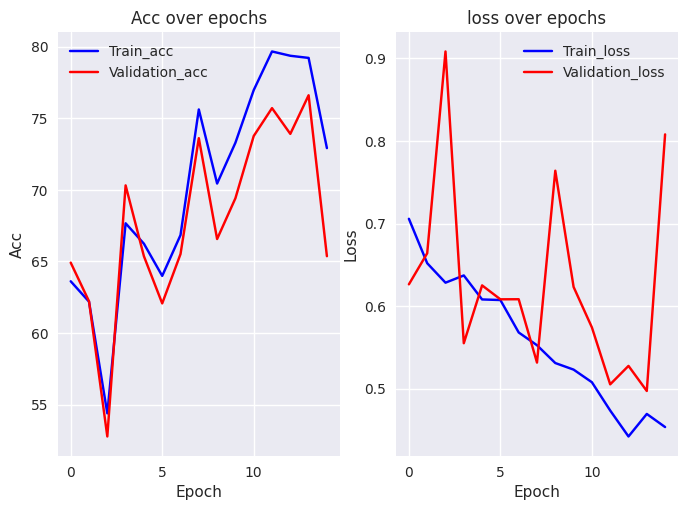

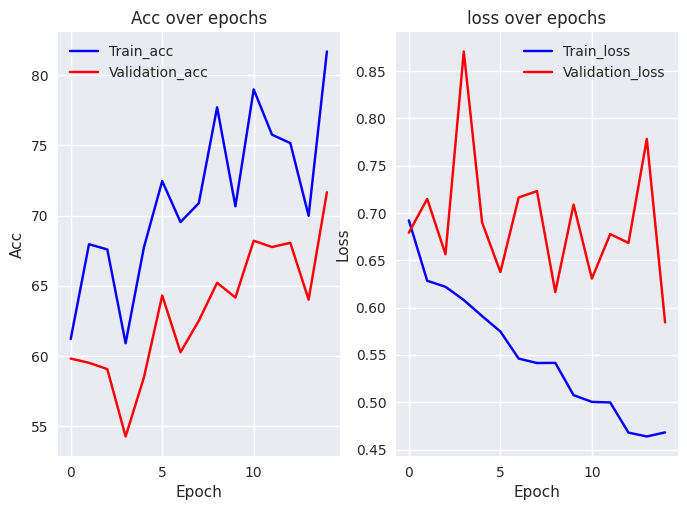

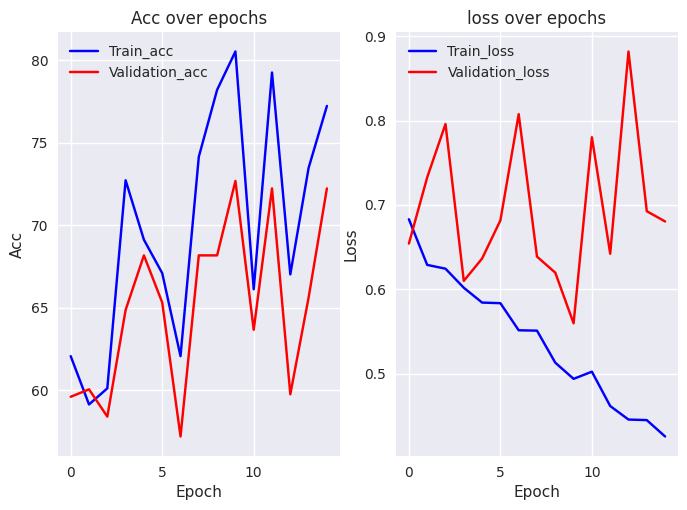

In [12]:
for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(transformed_train_data)))):
  print('############### Fold {} ###############'.format(fold_idx + 1))
  train_loader, val_loader = setup_dataflow(transformed_train_data, train_idx, val_idx)
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # 0.0001
  loss_function = nn.CrossEntropyLoss()
  model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, val_loader, 15, device, fold_idx)


# TTA

In [20]:
# 75.7%
loaded_model_1 = Net().to(device)
loaded_model_1.load_state_dict(torch.load('/content/save_model/fold_1_epoch_11_acc75.71214392803599.pth'))

<All keys matched successfully>

In [21]:
# 64.2%
loaded_model_2 = Net().to(device)
loaded_model_2.load_state_dict(torch.load('/content/save_model/fold_2_epoch_9_acc64.16791604197901.pth'))

<All keys matched successfully>

In [22]:
# 72.67%
loaded_model_3 = Net().to(device)
loaded_model_3.load_state_dict(torch.load('/content/save_model/fold_3_epoch_9_acc72.67267267267268.pth'))

<All keys matched successfully>

In [23]:
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

In [24]:
# augment test
test_acc_1 = get_accuracy(loaded_model_1, test_data_loader, device)
test_acc_2 = get_accuracy(loaded_model_2, test_data_loader, device)
test_acc_3 = get_accuracy(loaded_model_3, test_data_loader, device)
print("test acc model1: ", test_acc_1)
print("test acc model2: ", test_acc_2)
print("test acc model3: ", test_acc_3)

test acc model1:  76.66666666666667
test acc model2:  67.83333333333333
test acc model3:  76.16666666666667


In [25]:
# without augment test
_transforms = albumentations.Compose([
        albumentations.Normalize()
])

In [26]:
_transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms_val)

In [27]:
_test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

In [28]:
# without augment test
test_acc_1 = get_accuracy(loaded_model_1, _test_data_loader, device)
test_acc_2 = get_accuracy(loaded_model_2, _test_data_loader, device)
test_acc_3 = get_accuracy(loaded_model_3, _test_data_loader, device)
print("test acc model1: ", test_acc_1)
print("test acc model2: ", test_acc_2)
print("test acc model3: ", test_acc_3)

test acc model1:  74.0
test acc model2:  65.5
test acc model3:  76.5
